# Train VGG16 network to classify lugol cervix images

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Project
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common'))

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

In [5]:
from vgg16_keras122 import get_vgg16

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [6]:
from keras.applications.vgg16 import VGG16

In [20]:
optimizer = 'adam'
lr_base = 0.0001

print("\n {} - Get VGG16 model ...".format(datetime.now()))
vgg = get_vgg16(trained=True, finetuning=True, optimizer=optimizer, lr=lr_base)


 2017-05-03 19:51:49.088667 - Get VGG16 model ...


In [8]:
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 224)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 224)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 112, 112)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

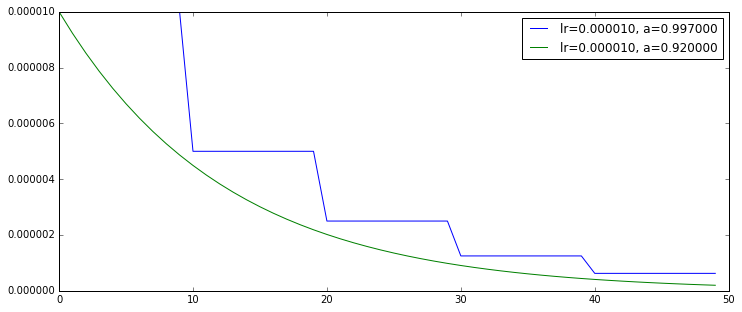

In [9]:
from training_utils import exp_decay, step_decay

lr_1 = 1.0 * lr_base; a_1 = 0.997
lr_2 = 1.0 * lr_base; a_2 = 0.92

epochs = np.arange(0, 50)
lrs_1 = step_decay(epochs, lr=lr_1, period=10)
lrs_2 = exp_decay(epochs, lr=lr_2, a=a_2)
plt_st(12, 5)
plt.plot(epochs, lrs_1, label="lr=%f, a=%f" % (lr_1, a_1))
plt.plot(epochs, lrs_2, label="lr=%f, a=%f" % (lr_2, a_2))
plt.legend()

In [10]:
seed = 54321
np.random.seed(seed)
save_prefix='vgg16_cervix_lugol_opt=%s_seed=%i' % (optimizer, seed)

In [13]:
from data_utils import GENERATED_DATA
print("\n {} - Get train/val lists ...".format(datetime.now()))

trainval_lugol_id_type_list = np.load(os.path.join(GENERATED_DATA, 'lugol_id_type_list_final.npz'))['lugol_id_type_list']

def generate_trainval(id_type_list, seed, val_split=0.15):
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    out = [None, None, None]
    np.random.seed(seed)  
    for i, ts in enumerate(types):
        o = id_type_list[(id_type_list[:, 1] == ts[0]) | (id_type_list[:, 1] == ts[1])]
        out[i] = o

    ll = min([len(o) for o in out])
    out = np.array([o[:ll] for o in out])
    out = out.reshape((3 * ll, 2))  
    np.random.shuffle(out)
    ll = int(len(out) * (1.0 - val_split))
    train_id_type_list = out[:ll]
    val_id_type_list = out[ll:]
    return train_id_type_list, val_id_type_list
    
train_id_type_list, val_id_type_list = generate_trainval(trainval_lugol_id_type_list, seed)
print(len(train_id_type_list), len(val_id_type_list))


 2017-05-03 19:24:52.920518 - Get train/val lists ...
(405, 72)


In [14]:
def compute_type_distribution(id_type_list):
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    ll = len(id_type_list)
    out = [0.0, 0.0, 0.0]
    for i, ts in enumerate(types):
        for t in ts:
            out[i] += (id_type_list[:, 1] == t).sum()        
        out[i] *= 1.0 / ll
    return out

print compute_type_distribution(trainval_lugol_id_type_list)
print compute_type_distribution(train_id_type_list)
print compute_type_distribution(val_id_type_list)

[0.10311284046692606, 0.38002594033722437, 0.5168612191958495]
[0.3234567901234568, 0.3358024691358025, 0.34074074074074073]
[0.38888888888888884, 0.3194444444444444, 0.29166666666666663]


In [15]:
from glob import glob
from training_utils import find_best_weights_file

# best_weights_filename = "weights/vgg16_cervix_opt=adam_seed=2017_07_val_loss=0.6447_val_acc=0.7594_val_precision=0.7701_val_recall=0.7353.h5"
# if len(best_weights_filename) > 0:
#     # load weights to the model
#     print("Load found weights: ", best_weights_filename)
#     vgg.load_weights(best_weights_filename)

In [16]:
from xy_providers import DataCache
# cache = DataCache(0)

In [21]:
if True:
    from training_utils import classification_train as train
      
    nb_epochs = 25
    batch_size = 4
    
    lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, period=5) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(vgg, 
              train_id_type_list, 
              val_id_type_list, 
              option='cervix',
              normalization='vgg',
              nb_epochs=nb_epochs,
              samples_per_epoch=3.0 * len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              seed=seed,
              save_prefix=save_prefix)


 2017-05-03 19:51:56.850116 - Start training ...

-- Training parameters: 4, 25, 1216, 76
('Image normalization: ', 'vgg')

-- Fit model
Epoch 1/25
1216/1216 [==============================] - 189s - loss: 6.9580 - acc: 0.3758 - precision: 0.3750 - recall: 0.3742 - val_loss: 5.8797 - val_acc: 0.4474 - val_precision: 0.4518 - val_recall: 0.4474
Epoch 2/25
1216/1216 [==============================] - 188s - loss: 5.3310 - acc: 0.4605 - precision: 0.4619 - recall: 0.4589 - val_loss: 4.7398 - val_acc: 0.3553 - val_precision: 0.3553 - val_recall: 0.3553
Epoch 3/25
1216/1216 [==============================] - 190s - loss: 2.3736 - acc: 0.5173 - precision: 0.5208 - recall: 0.5132 - val_loss: 2.0851 - val_acc: 0.5132 - val_precision: 0.5219 - val_recall: 0.5132
Epoch 4/25
1216/1216 [==============================] - 188s - loss: 1.4284 - acc: 0.5987 - precision: 0.6080 - recall: 0.5839 - val_loss: 1.9266 - val_acc: 0.4342 - val_precision: 0.4342 - val_recall: 0.4342
Epoch 5/25
1216/1216 [====

In [21]:
from training_utils import classification_validate as validate
from test_utils import classification_predict as predict

batch_size = 4

In [57]:
print("\n {} - Start validation ...".format(datetime.now()))
validate(vgg, 
         val_id_type_list,
         option='cervix',
         normalization='vgg',
         save_prefix=save_prefix, 
         batch_size=batch_size, 
         xy_provider_cache=cache)


 2017-05-02 08:16:31.678737 - Start validation ...
('Image normalization: ', 'vgg')
('--', 8, 'batch loss : ', 0.7920593, ' | info:', array([('2605', 'AType_2'), ('1132', 'AType_3'), ('3463', 'AType_1'),
       ('1437', 'AType_2'), ('2134', 'AType_1'), ('2096', 'AType_2'),
       ('2909', 'AType_1'), ('1793', 'AType_1')], dtype=object))
('--', 16, 'batch loss : ', 0.052994706, ' | info:', array([('1682', 'AType_3'), ('804', 'AType_2'), ('216', 'Type_2'),
       ('1204', 'AType_1'), ('584', 'AType_2'), ('269', 'AType_3'),
       ('3250', 'AType_2'), ('2428', 'AType_2')], dtype=object))
('--', 24, 'batch loss : ', 0.1406433, ' | info:', array([('3695', 'AType_3'), ('271', 'Type_2'), ('165', 'AType_2'),
       ('5615', 'AType_3'), ('215', 'Type_1'), ('2441', 'AType_2'),
       ('3295', 'AType_2'), ('210', 'Type_2')], dtype=object))
('--', 32, 'batch loss : ', 0.68083584, ' | info:', array([('1141', 'AType_1'), ('1355', 'Type_3'), ('5459', 'AType_3'),
       ('6837', 'AType_3'), ('331', '

In [22]:
print("\n {} - Start predictions and write submission ...".format(datetime.now()))
from test_utils import get_test_id_type_list
test_id_type_list = get_test_id_type_list()

# test_normal_id_type_list = np.load(os.path.join(GENERATED_DATA, 'test_normal_id_type_list.npz'))['test_normal_id_type_list']

predict(vgg, 
        test_id_type_list, 
        option='cervix',
        normalize_data=True,
        normalization='vgg',
        save_prefix=save_prefix, 
        info=save_prefix, 
        batch_size=batch_size)


 2017-05-02 19:04:25.103103 - Start predictions and write submission ...
('Image normalization: ', 'vgg')
('--', 0, '/', 512)
('--', 4, '/', 512)
('--', 8, '/', 512)
('--', 12, '/', 512)
('--', 16, '/', 512)
('--', 20, '/', 512)
('--', 24, '/', 512)
('--', 28, '/', 512)
('--', 32, '/', 512)
('--', 36, '/', 512)
('--', 40, '/', 512)
('--', 44, '/', 512)
('--', 48, '/', 512)
('--', 52, '/', 512)
('--', 56, '/', 512)
('--', 60, '/', 512)
('--', 64, '/', 512)
('--', 68, '/', 512)
('--', 72, '/', 512)
('--', 76, '/', 512)
('--', 80, '/', 512)
('--', 84, '/', 512)
('--', 88, '/', 512)
('--', 92, '/', 512)
('--', 96, '/', 512)
('--', 100, '/', 512)
('--', 104, '/', 512)
('--', 108, '/', 512)
('--', 112, '/', 512)
('--', 116, '/', 512)
('--', 120, '/', 512)
('--', 124, '/', 512)
('--', 128, '/', 512)
('--', 132, '/', 512)
('--', 136, '/', 512)
('--', 140, '/', 512)
('--', 144, '/', 512)
('--', 148, '/', 512)
('--', 152, '/', 512)
('--', 156, '/', 512)
('--', 160, '/', 512)
('--', 164, '/', 51

## Analyse predictions

In [15]:
batch_size = 4
from data_utils import GENERATED_DATA
from image_utils import scale_percentile
from xy_providers import cached_image_label_provider
from preprocessing.image.generators import ImageDataGenerator

normalize_data = True
image_size = (224, 224)
channels_first = True

xy_provider = cached_image_label_provider
val_gen = ImageDataGenerator(featurewise_center=normalize_data,
                             featurewise_std_normalization=normalize_data)

if normalize_data:
    val_gen.std = 1.0 / 255.0  # Rescale to [0.0, 255.0]
    m = np.array([123.68, 116.779, 103.939]) / 255.0 # RGB
    if channels_first:                
        m = m[:, None, None]
    else:
        m = m[None, None, :]
    val_gen.mean = m   
        
          
flow = val_gen.flow(xy_provider(val_id_type_list,
                                image_size=image_size,
                                channels_first=channels_first,
                                cache=cache,
                                test_mode=True),
                    # Ensure that all batches have the same size
                    len(val_id_type_list),
                    batch_size=batch_size)
total_counter = 0

('--', 4)
(('2275', 'AType_1'), array([  9.97017384e-01,   2.20242050e-03,   7.80100876e-04], dtype=float32), array([1, 0, 0], dtype=uint8))
(('952', 'AType_2'), array([ 0.24421577,  0.52605635,  0.22972788], dtype=float32), array([0, 1, 0], dtype=uint8))
(('981', 'AType_2'), array([  3.11159622e-03,   9.96586561e-01,   3.01781925e-04], dtype=float32), array([0, 1, 0], dtype=uint8))
(('2642', 'AType_2'), array([  1.30929406e-13,   1.00000000e+00,   8.33007385e-10], dtype=float32), array([0, 1, 0], dtype=uint8))


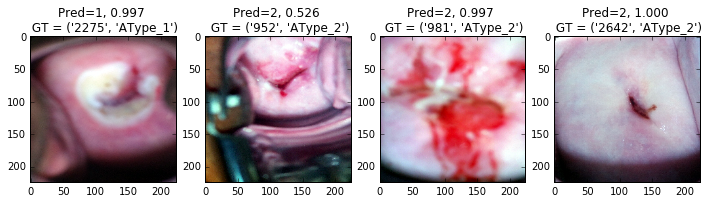

In [16]:
for x, y_true, info in flow:
    s = y_true.shape[0]
    y_pred = vgg.predict(x)
    print("--", total_counter*batch_size + s)    
    total_counter += 1
    plt_st(12, 4)
    for i in range(s):
        print(info[i], y_pred[i], y_true[i])
        plt.subplot(1, s, i+1)
        plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
        plt.imshow(scale_percentile(x[i, :, :, :].transpose([1, 2, 0])))
    break

In [19]:
(y_pred > 0.5).astype(np.float32)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]], dtype=float32)

### Logs


xception_trained_3_dense_norm_cervix_adadelta_seed=2017

```
2017-04-10 08:19:13.163710 - Start training ...

-- Training parameters: 8, 50, 2048, 1024

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_3_dense_norm_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics

-- Fit model
- New Keras API found -
Epoch 1/50
256/256 [] - 556s - loss: 1.1825 - acc: 0.3726 - val_loss: 1.0385 - val_acc: 0.4961
Epoch 2/50
256/256 [] - 553s - loss: 1.0914 - acc: 0.4033 - val_loss: 0.9926 - val_acc: 0.5303
Epoch 3/50
256/256 [] - 553s - loss: 1.0382 - acc: 0.4731 - val_loss: 0.9482 - val_acc: 0.5234
Epoch 4/50
256/256 [] - 553s - loss: 0.9950 - acc: 0.4995 - val_loss: 0.9174 - val_acc: 0.5166
Epoch 5/50
256/256 [] - 552s - loss: 0.9920 - acc: 0.4951 - val_loss: 0.9064 - val_acc: 0.5439
Epoch 6/50
256/256 [] - 552s - loss: 0.9546 - acc: 0.5234 - val_loss: 0.8897 - val_acc: 0.5684
Epoch 7/50
256/256 [] - 552s - loss: 0.9595 - acc: 0.5293 - val_loss: 0.8812 - val_acc: 0.5566
Epoch 8/50
256/256 [] - 552s - loss: 0.9258 - acc: 0.5493 - val_loss: 0.9145 - val_acc: 0.5596
Epoch 9/50
256/256 [] - 552s - loss: 0.9310 - acc: 0.5591 - val_loss: 0.8834 - val_acc: 0.5596
Epoch 10/50
256/256 [] - 552s - loss: 0.9156 - acc: 0.5698 - val_loss: 0.8955 - val_acc: 0.5449
Epoch 11/50
256/256 [] - 552s - loss: 0.8982 - acc: 0.5835 - val_loss: 0.8951 - val_acc: 0.5791
Epoch 12/50
256/256 [] - 552s - loss: 0.9094 - acc: 0.5703 - val_loss: 0.8842 - val_acc: 0.5674
Epoch 13/50
256/256 [] - 552s - loss: 0.8871 - acc: 0.5840 - val_loss: 0.8860 - val_acc: 0.5654
Epoch 14/50
256/256 [] - 552s - loss: 0.9042 - acc: 0.5757 - val_loss: 0.9130 - val_acc: 0.5625
Epoch 15/50
256/256 [] - 552s - loss: 0.9078 - acc: 0.5708 - val_loss: 0.8937 - val_acc: 0.5713
Epoch 16/50
256/256 [] - 552s - loss: 0.8833 - acc: 0.5908 - val_loss: 0.8916 - val_acc: 0.5752
Epoch 17/50
256/256 [] - 552s - loss: 0.8741 - acc: 0.5977 - val_loss: 0.8919 - val_acc: 0.5879
Epoch 18/50
256/256 [] - 552s - loss: 0.8478 - acc: 0.6050 - val_loss: 0.9156 - val_acc: 0.5908
Epoch 19/50
256/256 [] - 552s - loss: 0.8587 - acc: 0.6030 - val_loss: 0.8996 - val_acc: 0.5752
Epoch 20/50
256/256 [] - 552s - loss: 0.8469 - acc: 0.6035 - val_loss: 0.9111 - val_acc: 0.5840
Epoch 21/50
256/256 [] - 551s - loss: 0.8540 - acc: 0.5879 - val_loss: 0.9184 - val_acc: 0.5830
Epoch 22/50
256/256 [] - 551s - loss: 0.8619 - acc: 0.5977 - val_loss: 0.9027 - val_acc: 0.5801
Epoch 23/50
256/256 [] - 551s - loss: 0.8428 - acc: 0.6079 - val_loss: 0.8925 - val_acc: 0.5830
Epoch 24/50
256/256 [] - 551s - loss: 0.8334 - acc: 0.6260 - val_loss: 0.9472 - val_acc: 0.5742
Epoch 25/50
256/256 [] - 551s - loss: 0.8232 - acc: 0.6211 - val_loss: 0.8903 - val_acc: 0.5967
Epoch 26/50
256/256 [] - 551s - loss: 0.8179 - acc: 0.6084 - val_loss: 0.9258 - val_acc: 0.5938
Epoch 27/50
256/256 [] - 551s - loss: 0.8404 - acc: 0.6157 - val_loss: 0.9566 - val_acc: 0.5781
Epoch 28/50
256/256 [] - 550s - loss: 0.8354 - acc: 0.6094 - val_loss: 0.9439 - val_acc: 0.5732
Epoch 29/50
256/256 [] - 550s - loss: 0.8341 - acc: 0.6309 - val_loss: 0.9647 - val_acc: 0.5957
Epoch 30/50
256/256 [] - 551s - loss: 0.8031 - acc: 0.6558 - val_loss: 0.9930 - val_acc: 0.5645
Epoch 31/50
256/256 [] - 551s - loss: 0.8363 - acc: 0.6235 - val_loss: 0.9227 - val_acc: 0.5947
Epoch 32/50
256/256 [] - 551s - loss: 0.8210 - acc: 0.6343 - val_loss: 0.9791 - val_acc: 0.5596
Epoch 33/50
256/256 [] - 550s - loss: 0.8151 - acc: 0.6206 - val_loss: 1.0454 - val_acc: 0.5420
Epoch 34/50
256/256 [] - 550s - loss: 0.8081 - acc: 0.6367 - val_loss: 0.9620 - val_acc: 0.5762
Epoch 35/50
256/256 [] - 551s - loss: 0.7813 - acc: 0.6538 - val_loss: 0.9378 - val_acc: 0.5977
Epoch 36/50
256/256 [] - 551s - loss: 0.8218 - acc: 0.6348 - val_loss: 0.9448 - val_acc: 0.5869
Epoch 37/50
256/256 [] - 551s - loss: 0.7898 - acc: 0.6465 - val_loss: 0.9622 - val_acc: 0.5947
Epoch 38/50
256/256 [] - 551s - loss: 0.7796 - acc: 0.6455 - val_loss: 0.9754 - val_acc: 0.5713
Epoch 39/50
256/256 [] - 551s - loss: 0.8165 - acc: 0.6401 - val_loss: 0.9620 - val_acc: 0.5703
Epoch 40/50
256/256 [] - 551s - loss: 0.7685 - acc: 0.6509 - val_loss: 1.0134 - val_acc: 0.5723
Epoch 41/50
256/256 [] - 551s - loss: 0.7765 - acc: 0.6592 - val_loss: 1.0378 - val_acc: 0.5791
Epoch 42/50
256/256 [] - 550s - loss: 0.7917 - acc: 0.6509 - val_loss: 1.0217 - val_acc: 0.5752
Epoch 43/50
256/256 [] - 550s - loss: 0.7902 - acc: 0.6426 - val_loss: 0.9581 - val_acc: 0.5830
Epoch 44/50
256/256 [] - 550s - loss: 0.7815 - acc: 0.6475 - val_loss: 0.9723 - val_acc: 0.5801
Epoch 45/50
256/256 [] - 550s - loss: 0.7825 - acc: 0.6504 - val_loss: 1.0255 - val_acc: 0.5918
Epoch 46/50
256/256 [] - 550s - loss: 0.7727 - acc: 0.6738 - val_loss: 1.0284 - val_acc: 0.5811
Epoch 47/50
256/256 [] - 551s - loss: 0.7582 - acc: 0.6826 - val_loss: 1.0273 - val_acc: 0.5723
Epoch 48/50
256/256 [] - 551s - loss: 0.7726 - acc: 0.6597 - val_loss: 1.0362 - val_acc: 0.5859
Epoch 49/50
256/256 [] - 551s - loss: 0.7416 - acc: 0.6699 - val_loss: 1.0400 - val_acc: 0.5801
Epoch 50/50
256/256 [] - 551s - loss: 0.8061 - acc: 0.6631 - val_loss: 0.9954 - val_acc: 0.5820
```


Shuffled data, val_split=0.2
Train ending blocks

```
 2017-04-09 23:18:02.045700 - Start training ...

-- Training parameters: 8, 50, 2048, 1024

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics

-- Fit model
- New Keras API found -
Epoch 1/50
256/256 [] - 628s - loss: 0.8440 - acc: 0.6152 - val_loss: 0.9302 - val_acc: 0.6084
Epoch 2/50
256/256 [] - 621s - loss: 0.7636 - acc: 0.6450 - val_loss: 1.0905 - val_acc: 0.5918
Epoch 3/50
256/256 [] - 592s - loss: 0.7233 - acc: 0.6802 - val_loss: 0.9233 - val_acc: 0.6084
Epoch 4/50
256/256 [] - 644s - loss: 0.7026 - acc: 0.6802 - val_loss: 1.0360 - val_acc: 0.6152
Epoch 5/50
256/256 [] - 659s - loss: 0.6462 - acc: 0.7207 - val_loss: 1.1449 - val_acc: 0.5869
Epoch 6/50
256/256 [] - 660s - loss: 0.6173 - acc: 0.7329 - val_loss: 1.0263 - val_acc: 0.5967
Epoch 7/50
256/256 [] - 638s - loss: 0.5828 - acc: 0.7578 - val_loss: 1.0891 - val_acc: 0.6162
Epoch 8/50
256/256 [] - 616s - loss: 0.5522 - acc: 0.7632 - val_loss: 1.1607 - val_acc: 0.6143
Epoch 9/50
256/256 [] - 661s - loss: 0.5296 - acc: 0.7793 - val_loss: 1.3640 - val_acc: 0.5850
Epoch 10/50
256/256 [] - 637s - loss: 0.4891 - acc: 0.7949 - val_loss: 1.2968 - val_acc: 0.5723
Epoch 11/50
256/256 [] - 664s - loss: 0.4715 - acc: 0.8047 - val_loss: 1.3433 - val_acc: 0.6182
Epoch 12/50
256/256 [] - 626s - loss: 0.4617 - acc: 0.8032 - val_loss: 1.2871 - val_acc: 0.5889
```


Shuffled data, val_split=0.2
```
 2017-04-09 21:59:45.992259 - Start training ...

-- Training parameters: 8, 50, 2048, 1024

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics

-- Fit model
- New Keras API found -
Epoch 1/50
256/256 [] - 597s - loss: 0.3834 - acc: 0.8442 - val_loss: 1.1990 - val_acc: 0.5430
Epoch 2/50
256/256 [] - 593s - loss: 0.7423 - acc: 0.6826 - val_loss: 1.1388 - val_acc: 0.5703
Epoch 3/50
256/256 [] - 613s - loss: 0.6842 - acc: 0.6899 - val_loss: 1.0178 - val_acc: 0.5869
Epoch 4/50
256/256 [] - 621s - loss: 0.6442 - acc: 0.7280 - val_loss: 1.1309 - val_acc: 0.5840
Epoch 5/50
256/256 [] - 607s - loss: 0.5886 - acc: 0.7427 - val_loss: 1.0864 - val_acc: 0.5996
Epoch 6/50
256/256 [] - 614s - loss: 0.5459 - acc: 0.7744 - val_loss: 1.2858 - val_acc: 0.5889
Epoch 7/50
 99/256 [==========>...................] - ETA: 261s - loss: 0.5064 - acc: 0.7955
```


```

 2017-04-09 00:37:21.308172 - Start training ...
-- Training parameters:  4 50 2048 1024
-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_original_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics
-- Fit model
Epoch 1/50

/Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/notebooks/../common/training_utils.py:362: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<preproces..., validation_data=<preproces..., validation_steps=1024, verbose=1, callbacks=[<keras.ca..., steps_per_epoch=512, epochs=50)`
  verbose=verbose,

512/512 [] - 4901s - loss: 0.9079 - acc: 0.5708 - val_loss: 0.9943 - val_acc: 0.6138
Epoch 2/50
512/512 [] - 4824s - loss: 0.7831 - acc: 0.6353 - val_loss: 1.2298 - val_acc: 0.5715
Epoch 3/50
512/512 [] - 4795s - loss: 0.7184 - acc: 0.6934 - val_loss: 1.2304 - val_acc: 0.5708
Epoch 4/50
512/512 [] - 4789s - loss: 0.6684 - acc: 0.7104 - val_loss: 1.0132 - val_acc: 0.6167
Epoch 5/50
512/512 [] - 4787s - loss: 0.6031 - acc: 0.7422 - val_loss: 1.2270 - val_acc: 0.6145
Epoch 6/50
512/512 [] - 4790s - loss: 0.5373 - acc: 0.7817 - val_loss: 1.2280 - val_acc: 0.6138
Epoch 7/50
512/512 [] - 4792s - loss: 0.4819 - acc: 0.7993 - val_loss: 1.2862 - val_acc: 0.6353
Epoch 8/50
512/512 [] - 4813s - loss: 0.4059 - acc: 0.8340 - val_loss: 1.9449 - val_acc: 0.6121
```

In [23]:
from metrics import logloss_mc

In [42]:
y_true = np.array([
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],        
])

y_pred = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],        
])


logloss_mc(y_true, y_pred)

34.538776394910684